In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx

import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

from shapely.geometry import Point
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler

from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from libpysal.weights import Queen, KNN
from esda.moran import Moran
from spreg import OLS, ML_Lag
from spreg import ML_Error

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def add_north_arrow(ax, bounds, scale_width=0.02, scale_height=0.05, fontsize=14, x_offset=0.95, y_offset=0.05):
    x = bounds[0] + (bounds[2] - bounds[0]) * x_offset
    y = bounds[3] - (bounds[3] - bounds[1]) * y_offset
    
    map_width = bounds[2] - bounds[0]
    map_height = bounds[3] - bounds[1]
    width = map_width * scale_width
    height = map_height * scale_height
    vertices = [
        (x, y), 
        (x - width/2, y - height), 
        (x + width/2, y - height), 
        (x, y)  
    ]
    codes = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
    path = Path(vertices, codes)
    
    arrow = PathPatch(path, facecolor='black', edgecolor='black')
    ax.add_patch(arrow)
    plt.text(x, y + height/4, 'N', 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=fontsize,
             fontweight='bold')

def add_scalebar(ax, bounds, length=5, label=None,
                 bar_height_ratio=0.01,
                 x_offset=0.95, y_offset=0.1,
                 color="black", lw=2, fontsize=10):
    if label is None:
        label = f"{length}"
    xmin, ymin, xmax, ymax = bounds
    map_width = xmax - xmin
    map_height = ymax - ymin
    x0 = xmin + map_width * x_offset
    y0 = ymin + map_height * y_offset

    bar_height = map_height * bar_height_ratio
    ax.plot([x0, x0 + length], [y0, y0], color=color, lw=lw, solid_capstyle='butt')
    ax.plot([x0, x0], [y0, y0 + bar_height], color=color, lw=lw)
    ax.plot([x0 + length, x0 + length], [y0, y0 + bar_height], color=color, lw=lw)
    ax.text(x0 + length / 2, y0 + bar_height * 2,
            label, ha='center', va='bottom',
            fontsize=fontsize, color=color, weight='bold')

# Data Input

In [3]:
London = gpd.read_file("boundaries/london_boundary/London_GLA_Boundary.shp")
LAD = gpd.read_file("boundaries/Local_Authority_Districts_December_2024_Boundaries_UK_BFC_-5800161498345042609.gpkg")
LAD = LAD[LAD["LAD24CD"].str.startswith("E09")]
len(LAD["LAD24NM"].unique())
LAD['lad_area_m2'] = LAD.geometry.area
LAD.head()

LAD24CD               LAD24NM LAD24NMW   BNG_E   BNG_N      LONG  \
263  E09000001        City of London           532382  181358 -0.093520   
264  E09000002  Barking and Dagenham           547757  185111  0.129479   
265  E09000003                Barnet           523473  191752 -0.218200   
266  E09000004                Bexley           549202  175434  0.146212   
267  E09000005                 Brent           519615  186465 -0.275690   

           LAT                                GlobalID  \
263  51.515640  {B9DB852A-88ED-40DC-982B-E815F889D4D4}   
264  51.545559  {241C4B7C-CC36-480A-9C1E-CAD6D53BA5ED}   
265  51.611069  {6D2E9D28-5BAB-4B74-BF81-81EB659210A3}   
266  51.458229  {B95765FD-8BDD-4336-ADCC-3F42E1F22960}   
267  51.564388  {22605C91-A88B-4290-8369-A17751CCF8EB}   

                                              geometry   lad_area_m2  
263  MULTIPOLYGON (((532140.296 182191.897, 532139....  2.889680e+06  
264  MULTIPOLYGON (((548881.785 190816.665, 548884....  3.610139e+07  
265  MULTIPOLYGON (((524579.897 198355.201, 524562....  8.676704e+07  
266  MULTIPOLYGON (((547869.85 181500, 547841.35 18...  6.057222e+07  
267  MULTIPOLYGON (((520278.817 190250.43, 520265.2...  4.323637e+07

In [45]:
gdf = gpd.read_file('variables_lsoa_std.gpkg')

In [4]:
df = gpd.read_file('variables_lsoa_std.gpkg')
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          4994 non-null   int64   
 1   female%_log_std             4994 non-null   float64 
 2   children%_log_std           4994 non-null   float64 
 3   elder%_log_std              4994 non-null   float64 
 4   minority_groups%_log_std    4994 non-null   float64 
 5   Buddhist%_yj_std            4994 non-null   float64 
 6   Hindu%_yj_std               4994 non-null   float64 
 7   Jewish%_yj_std              4994 non-null   float64 
 8   Muslim%_log_std             4994 non-null   float64 
 9   Sikh%_yj_std                4994 non-null   float64 
 10  Other religion%_yj_std      4994 non-null   float64 
 11  No_religion%_log_std        4994 non-null   float64 
 12  bad_heath%_log_std          4994 non-null   float64 
 13  disabled%_

In [5]:
df_1 = pd.read_csv("lsoa_DS.csv")
df_1['id'] = [str(i) for i in range(len(df_1))]
df_1['id'] = df_1['id'].astype(int)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   LSOA 2021 Code   4994 non-null   object
 1   LSOA 2021 Name   4994 non-null   object
 2   Total_residents  4994 non-null   int64 
 3   children         4994 non-null   int64 
 4   elder            4994 non-null   int64 
 5   bad_health       4994 non-null   int64 
 6   id               4994 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 273.2+ KB


In [6]:
df_2 = df.merge(df_1, on='id', how='left')
df_2.info()
df_2.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          4994 non-null   int64   
 1   female%_log_std             4994 non-null   float64 
 2   children%_log_std           4994 non-null   float64 
 3   elder%_log_std              4994 non-null   float64 
 4   minority_groups%_log_std    4994 non-null   float64 
 5   Buddhist%_yj_std            4994 non-null   float64 
 6   Hindu%_yj_std               4994 non-null   float64 
 7   Jewish%_yj_std              4994 non-null   float64 
 8   Muslim%_log_std             4994 non-null   float64 
 9   Sikh%_yj_std                4994 non-null   float64 
 10  Other religion%_yj_std      4994 non-null   float64 
 11  No_religion%_log_std        4994 non-null   float64 
 12  bad_heath%_log_std          4994 non-null   float64 
 13  disabled%_

id  female%_log_std  children%_log_std  elder%_log_std  \
0   0        -2.463871          -2.816887        1.716931   
1   1        -3.881470          -3.979872        1.252814   
2   2        -2.309066          -3.451397        0.990899   
3   3        -0.933471          -1.451380       -0.292308   
4   4        -6.500336          -4.930885       -1.990881   

   minority_groups%_log_std  Buddhist%_yj_std  Hindu%_yj_std  Jewish%_yj_std  \
0                 -0.786474         -0.112070      -0.005052        1.338161   
1                 -0.623950         -0.019379      -0.543551        1.497593   
2                 -0.478675          0.256732      -0.823392        1.527591   
3                  0.726820         -0.204973      -0.584817        1.001810   
4                  0.284750          1.471405       0.500227        1.400608   

   Muslim%_log_std  Sikh%_yj_std  ...  pop_density_log_std  \
0        -1.770601     -1.409412  ...             0.458440   
1        -1.900242     -1.409412  ...            -0.434997   
2        -1.423990     -0.695025  ...             2.938735   
3         1.340914     -1.409412  ...            -0.180794   
4        -1.429025     -0.206083  ...            -1.231585   

   total_open_space_m2_yj_std  Ga2SFCA_score_yj_std  \
0                    0.356338             -0.425353   
1                    0.401150             -0.495482   
2                    0.319456             -0.550066   
3                    0.282056              2.635092   
4                    1.982322              2.634037   

                                            geometry  LSOA 2021 Code  \
0  MULTIPOLYGON (((532151.538 181867.433, 532152....       E01000001   
1  MULTIPOLYGON (((532634.497 181926.016, 532632....       E01000002   
2  MULTIPOLYGON (((532153.703 182165.155, 532158....       E01000003   
3  MULTIPOLYGON (((533619.062 181402.364, 533639....       E01000005   
4  MULTIPOLYGON (((533376.156 181863.888, 533372....       E01032739   

        LSOA 2021 Name  Total_residents  children  elder  bad_health  
0  City of London 001A             1795       119    372          28  
1  City of London 001B             1671        79    278          31  
2  City of London 001C             1896       108    287          49  
3  City of London 001E             1737       129    104          80  
4  City of London 001F             2548        69     62          26  

[5 rows x 27 columns]

In [7]:
df_2['area'] = df_2['geometry'].area
df_2['child_density'] = df_2['children'] / df_2['area']
df_2['elder_density'] = df_2['elder'] / df_2['area']
df_2['bad_health_density'] = df_2['bad_health'] / df_2['area']
df_2.head()

id  female%_log_std  children%_log_std  elder%_log_std  \
0   0        -2.463871          -2.816887        1.716931   
1   1        -3.881470          -3.979872        1.252814   
2   2        -2.309066          -3.451397        0.990899   
3   3        -0.933471          -1.451380       -0.292308   
4   4        -6.500336          -4.930885       -1.990881   

   minority_groups%_log_std  Buddhist%_yj_std  Hindu%_yj_std  Jewish%_yj_std  \
0                 -0.786474         -0.112070      -0.005052        1.338161   
1                 -0.623950         -0.019379      -0.543551        1.497593   
2                 -0.478675          0.256732      -0.823392        1.527591   
3                  0.726820         -0.204973      -0.584817        1.001810   
4                  0.284750          1.471405       0.500227        1.400608   

   Muslim%_log_std  Sikh%_yj_std  ...  LSOA 2021 Code       LSOA 2021 Name  \
0        -1.770601     -1.409412  ...       E01000001  City of London 001A   
1        -1.900242     -1.409412  ...       E01000002  City of London 001B   
2        -1.423990     -0.695025  ...       E01000003  City of London 001C   
3         1.340914     -1.409412  ...       E01000005  City of London 001E   
4        -1.429025     -0.206083  ...       E01032739  City of London 001F   

   Total_residents  children  elder  bad_health          area  child_density  \
0             1795       119    372          28  1.298653e+05       0.000916   
1             1671        79    278          31  2.284198e+05       0.000346   
2             1896       108    287          49  5.905420e+04       0.001829   
3             1737       129    104          80  1.895777e+05       0.000680   
4             2548        69     62          26  1.644423e+06       0.000042   

   elder_density  bad_health_density  
0       0.002865            0.000216  
1       0.001217            0.000136  
2       0.004860            0.000830  
3       0.000549            0.000422  
4       0.000038            0.000016  

[5 rows x 31 columns]

In [8]:
df_2.columns

Index(['id', 'female%_log_std', 'children%_log_std', 'elder%_log_std',
       'minority_groups%_log_std', 'Buddhist%_yj_std', 'Hindu%_yj_std',
       'Jewish%_yj_std', 'Muslim%_log_std', 'Sikh%_yj_std',
       'Other religion%_yj_std', 'No_religion%_log_std', 'bad_heath%_log_std',
       'disabled%_log_std', 'speakEng_notwell%_yj_std', 'rent%_log_std',
       'unemployed%_log_std', 'pop_density_log_std',
       'total_open_space_m2_yj_std', 'Ga2SFCA_score_yj_std', 'geometry',
       'LSOA 2021 Code', 'LSOA 2021 Name', 'Total_residents', 'children',
       'elder', 'bad_health', 'area', 'child_density', 'elder_density',
       'bad_health_density'],
      dtype='object')

In [9]:
df_3 = df_2[['id','LSOA 2021 Code', 'LSOA 2021 Name', 'child_density', 'Total_residents',
             'children', 'elder', 'bad_health','elder_density','bad_health_density', 'geometry']]

df_3.head()

id LSOA 2021 Code       LSOA 2021 Name  child_density  Total_residents  \
0   0      E01000001  City of London 001A       0.000916             1795   
1   1      E01000002  City of London 001B       0.000346             1671   
2   2      E01000003  City of London 001C       0.001829             1896   
3   3      E01000005  City of London 001E       0.000680             1737   
4   4      E01032739  City of London 001F       0.000042             2548   

   children  elder  bad_health  elder_density  bad_health_density  \
0       119    372          28       0.002865            0.000216   
1        79    278          31       0.001217            0.000136   
2       108    287          49       0.004860            0.000830   
3       129    104          80       0.000549            0.000422   
4        69     62          26       0.000038            0.000016   

                                            geometry  
0  MULTIPOLYGON (((532151.538 181867.433, 532152....  
1  MULTIPOLYGON (((532634.497 181926.016, 532632....  
2  MULTIPOLYGON (((532153.703 182165.155, 532158....  
3  MULTIPOLYGON (((533619.062 181402.364, 533639....  
4  MULTIPOLYGON (((533376.156 181863.888, 533372....

In [10]:
orig = gpd.read_file("POS_Accessibility/orig11.csv")
dest = gpd.read_file("POS_Accessibility/dest11.csv")
orig.info()
dest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   field_1     4994 non-null   object
 1   id          4994 non-null   object
 2   total_resi  4994 non-null   object
 3   geometry    4994 non-null   object
 4   lon         4994 non-null   object
 5   lat         4994 non-null   object
 6   nodes       4994 non-null   object
dtypes: object(7)
memory usage: 273.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30136 entries, 0 to 30135
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   field_1     30136 non-null  object
 1   id          30136 non-null  object
 2   AreaHa      30136 non-null  object
 3   PrimaryUse  30136 non-null  object
 4   geometry    30136 non-null  object
 5   lon         30136 non-null  object
 6   lat         30136 non-null  object
 7   nodes       30136 n

In [11]:
orig['id'] = orig['id'].astype(int)

In [12]:
orig = orig.drop(columns = ['geometry'])

In [13]:
orig1 = orig.merge(df_3, on='id', how='left')
orig1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   field_1             4994 non-null   object  
 1   id                  4994 non-null   int64   
 2   total_resi          4994 non-null   object  
 3   lon                 4994 non-null   object  
 4   lat                 4994 non-null   object  
 5   nodes               4994 non-null   object  
 6   LSOA 2021 Code      4994 non-null   object  
 7   LSOA 2021 Name      4994 non-null   object  
 8   child_density       4994 non-null   float64 
 9   Total_residents     4994 non-null   int64   
 10  children            4994 non-null   int64   
 11  elder               4994 non-null   int64   
 12  bad_health          4994 non-null   int64   
 13  elder_density       4994 non-null   float64 
 14  bad_health_density  4994 non-null   float64 
 15  geometry            4994 non-null   ge

In [14]:
distance_matrix = pd.read_csv("POS_Accessibility/distance_matrix.csv")
distance_matrix.info()
distance_matrix.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Columns: 30137 entries, Unnamed: 0 to 147038925.1
dtypes: float64(30136), int64(1)
memory usage: 1.1 GB


Unnamed: 0  263060306  278787040  249315586  278313518  249309903  \
0    20460697        inf        inf        inf        inf        inf   
1   748941508        inf        inf        inf        inf        inf   
2  1155584130        inf        inf        inf        inf        inf   
3  4715263992        inf        inf        inf        inf        inf   
4  2218344505        inf        inf        inf        inf        inf   

   249310858  249156360  102990235  610858007  ...  61274433.2  1253220844.5  \
0        inf        inf        inf        inf  ...         inf           inf   
1        inf        inf        inf        inf  ...         inf           inf   
2        inf        inf        inf        inf  ...         inf           inf   
3        inf        inf        inf        inf  ...         inf           inf   
4        inf        inf        inf        inf  ...         inf           inf   

   1253220844.6  61273883.8  61273883.9  1253220844.7  7128286822.10  \
0           inf         inf         inf           inf            inf   
1           inf         inf         inf           inf            inf   
2           inf         inf         inf           inf            inf   
3           inf         inf         inf           inf            inf   
4           inf         inf         inf           inf            inf   

   6953357720  60366004.3  147038925.1  
0         inf         inf          inf  
1         inf         inf          inf  
2         inf         inf          inf  
3         inf         inf          inf  
4         inf         inf          inf  

[5 rows x 30137 columns]

In [15]:
# change the distance matrix to numpy array for the calculation
distance_matrix_np = distance_matrix.values
# remove the first column of the distance matrix
distance_matrix_clean = distance_matrix_np[:, 1:] 
# check the shape of the distance matrix -- (4994, 30136)
print(distance_matrix_clean.shape)

(4994, 30136)


## distance matrix processing

In [16]:
distance_matrix1 = distance_matrix.copy()

In [17]:
distance_matrix1.head()

Unnamed: 0  263060306  278787040  249315586  278313518  249309903  \
0    20460697        inf        inf        inf        inf        inf   
1   748941508        inf        inf        inf        inf        inf   
2  1155584130        inf        inf        inf        inf        inf   
3  4715263992        inf        inf        inf        inf        inf   
4  2218344505        inf        inf        inf        inf        inf   

   249310858  249156360  102990235  610858007  ...  61274433.2  1253220844.5  \
0        inf        inf        inf        inf  ...         inf           inf   
1        inf        inf        inf        inf  ...         inf           inf   
2        inf        inf        inf        inf  ...         inf           inf   
3        inf        inf        inf        inf  ...         inf           inf   
4        inf        inf        inf        inf  ...         inf           inf   

   1253220844.6  61273883.8  61273883.9  1253220844.7  7128286822.10  \
0           inf         inf         inf           inf            inf   
1           inf         inf         inf           inf            inf   
2           inf         inf         inf           inf            inf   
3           inf         inf         inf           inf            inf   
4           inf         inf         inf           inf            inf   

   6953357720  60366004.3  147038925.1  
0         inf         inf          inf  
1         inf         inf          inf  
2         inf         inf          inf  
3         inf         inf          inf  
4         inf         inf          inf  

[5 rows x 30137 columns]

In [18]:
distance_matrix1=distance_matrix1.drop(columns=['Unnamed: 0'])
distance_matrix1.head()

263060306  278787040  249315586  278313518  249309903  249310858  \
0        inf        inf        inf        inf        inf        inf   
1        inf        inf        inf        inf        inf        inf   
2        inf        inf        inf        inf        inf        inf   
3        inf        inf        inf        inf        inf        inf   
4        inf        inf        inf        inf        inf        inf   

   249156360  102990235  610858007  416029258  ...  61274433.2  1253220844.5  \
0        inf        inf        inf        inf  ...         inf           inf   
1        inf        inf        inf        inf  ...         inf           inf   
2        inf        inf        inf        inf  ...         inf           inf   
3        inf        inf        inf        inf  ...         inf           inf   
4        inf        inf        inf        inf  ...         inf           inf   

   1253220844.6  61273883.8  61273883.9  1253220844.7  7128286822.10  \
0           inf         inf         inf           inf            inf   
1           inf         inf         inf           inf            inf   
2           inf         inf         inf           inf            inf   
3           inf         inf         inf           inf            inf   
4           inf         inf         inf           inf            inf   

   6953357720  60366004.3  147038925.1  
0         inf         inf          inf  
1         inf         inf          inf  
2         inf         inf          inf  
3         inf         inf          inf  
4         inf         inf          inf  

[5 rows x 30136 columns]

In [19]:
distance_matrix2 = distance_matrix1.T

In [20]:
distance_matrix2.head()

0     1     2     3     4     5     6     7     8     9     ...  \
263060306   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   
278787040   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   
249315586   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   
278313518   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   
249309903   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   

           4984  4985  4986  4987  4988  4989  4990  4991  4992  4993  
263060306   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  
278787040   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  
249315586   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  
278313518   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  
249309903   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  

[5 rows x 4994 columns]

In [21]:
distance_matrix3 = distance_matrix2.reset_index()
distance_matrix3.drop(columns=['index'],inplace=True)
distance_matrix3.tail(15)

0     1     2     3     4     5     6     7     8     9     ...  4984  \
30121   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30122   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30123   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30124   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30125   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30126   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30127   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30128   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30129   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30130   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30131   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30132   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30133   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30134   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
30135   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   

       4985  4986  4987  4988  4989  4990  4991  4992  4993  
30121   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30122   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30123   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30124   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30125   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30126   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30127   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30128   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30129   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30130   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30131   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30132   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30133   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30134   inf   inf   inf   inf   inf   inf   inf   inf   inf  
30135   inf   inf   inf   inf   inf   inf   inf   inf   inf  

[15 rows x 4994 columns]

In [22]:
distance_matrix3['destid'] = [str(i) for i in range(len(distance_matrix3))]

In [23]:
distance_matrix3.head()

0    1    2    3    4    5    6    7    8    9  ...  4985  4986  4987  \
0  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
1  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
2  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
3  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
4  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   

   4988  4989  4990  4991  4992  4993  destid  
0   inf   inf   inf   inf   inf   inf       0  
1   inf   inf   inf   inf   inf   inf       1  
2   inf   inf   inf   inf   inf   inf       2  
3   inf   inf   inf   inf   inf   inf       3  
4   inf   inf   inf   inf   inf   inf       4  

[5 rows x 4995 columns]

In [24]:
cols = ['destid'] + [col for col in distance_matrix3.columns if col != 'destid']
distance_matrix3 = distance_matrix3[cols]
distance_matrix3.head()

destid    0    1    2    3    4    5    6    7    8  ...  4984  4985  4986  \
0      0  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
1      1  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
2      2  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
3      3  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   
4      4  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   inf   

   4987  4988  4989  4990  4991  4992  4993  
0   inf   inf   inf   inf   inf   inf   inf  
1   inf   inf   inf   inf   inf   inf   inf  
2   inf   inf   inf   inf   inf   inf   inf  
3   inf   inf   inf   inf   inf   inf   inf  
4   inf   inf   inf   inf   inf   inf   inf  

[5 rows x 4995 columns]

In [25]:
distance_matrix3

destid    0    1    2    3    4    5    6    7    8  ...  4984  4985  \
0          0  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
1          1  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
2          2  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
3          3  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
4          4  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
30131  30131  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
30132  30132  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
30133  30133  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
30134  30134  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   
30135  30135  inf  inf  inf  inf  inf  inf  inf  inf  inf  ...   inf   inf   

       4986  4987  4988  4989  4990  4991  4992  4993  
0       inf   inf   inf   inf   inf   inf   inf   inf  
1       inf   inf   inf   inf   inf   inf   inf   inf  
2       inf   inf   inf   inf   inf   inf   inf   inf  
3       inf   inf   inf   inf   inf   inf   inf   inf  
4       inf   inf   inf   inf   inf   inf   inf   inf  
...     ...   ...   ...   ...   ...   ...   ...   ...  
30131   inf   inf   inf   inf   inf   inf   inf   inf  
30132   inf   inf   inf   inf   inf   inf   inf   inf  
30133   inf   inf   inf   inf   inf   inf   inf   inf  
30134   inf   inf   inf   inf   inf   inf   inf   inf  
30135   inf   inf   inf   inf   inf   inf   inf   inf  

[30136 rows x 4995 columns]

In [26]:
dest['PrimaryUse'].value_counts()

PrimaryUse
Amenity green space            5240
Park                           5216
River                          4216
Nature reserve                 1964
Formal garden                  1748
Recreation ground              1592
Walking/cycling route          1536
Cemetery/churchyard            1536
Canal                          1496
Common                         1136
Playing fields                  980
Play space                      916
Public woodland                 700
Civic/market square             628
Other recreational              340
Community garden                220
Allotments                      140
Village green                   120
Country park                    108
Sewage/water works              100
Adventure playground             56
City farm                        52
Road island/verge                40
Youth area                       24
Other hard surfaced areas        20
Landscaping around premises       8
                                  4
Name: count, dtyp

# Children's demand

In [28]:
import pandas as pd

# define children space
children_keywords = ['Play space', 'Playing fields', 'Recreation ground', 'Youth area',
'Adventure playground','Park','Amenity green space']

# select children space
mask = dest['PrimaryUse'].str.lower().isin([k.lower() for k in children_keywords])

# extract 'id'
children_space_ids = dest.loc[mask, 'id'].tolist()

print(f"count of children space: {len(children_space_ids)}")
print(f"children space id list: {children_space_ids[:5]} ...")

count of children space: 14024
children space id list: ['376', '377', '379', '381', '382'] ...


In [29]:
# filter rows where 'id' is in children_space_ids
children_dest = dest[dest['id'].isin(children_space_ids)].copy()

print(children_dest.shape)
print(children_dest.head())

(14024, 8)
    field_1   id  AreaHa           PrimaryUse  \
376     376  376  0.4298  Amenity green space   
377     377  377  0.4298  Amenity green space   
379     379  379  0.1926                 Park   
381     381  381  0.6357           Play space   
382     382  382  7.4318                 Park   

                                         geometry                  lon  \
376  POINT (557539.0658484678 188084.94264508833)   0.2717651779762906   
377    POINT (557515.3209708774 188001.804257171)   0.2713856201969249   
379   POINT (557751.8982031714 187256.6341707619)  0.27446216030779147   
381  POINT (557556.4889462487 188196.55158500912)   0.2720663598038448   
382    POINT (557977.9899018401 188284.333118075)    0.278182647344471   

                   lat      nodes  
376  51.56963222783138  191029015  
377  51.56889190336494  191028007  
379  51.56213089158558  191036124  
381  51.57063010799202  191029015  
382  51.57130093347046  406922899  


In [30]:
children_space_ids = [int(i) for i in children_space_ids]
distance_matrix3['destid'] = distance_matrix3['destid'].astype(int)
df_children_od = distance_matrix3[distance_matrix3['destid'].isin(children_space_ids)]

In [31]:
children_od = df_children_od.drop(columns=['destid']).T
children_od

376    377    379    381    382    383    385    386    390    391    \
0       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
1       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
2       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
3       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4989    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4990    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4991    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4992    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4993    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   

      ...  28679  28680  28681  28682  28683  28684  28685  28686  28695  \
0     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
1     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
2     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
3     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4989  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4990  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4991  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4992  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4993  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   

      28696  
0       inf  
1       inf  
2       inf  
3       inf  
4       inf  
...     ...  
4989    inf  
4990    inf  
4991    inf  
4992    inf  
4993    inf  

[4994 rows x 14024 columns]

In [32]:
def calculate_g2sfca(orig1, dest1, distance_matrix, 
                     demand_col='Total_resi',
                     supply_col='AreaHa',
                     time_threshold=15, 
                     beta=None):
    """
    Calculate the G2SFCA (Gaussian Two-Step Floating Catchment Area) with Gaussian decay function.

    Parameters:
    - demand_col: str, column in orig1 for demand (e.g., 'total_resi', 'children_count')
    - supply_col: str, column in dest1 for supply (e.g., 'AreaHa')
    """

    # convert to numerical type, handle missing values
    orig1[demand_col] = pd.to_numeric(orig1[demand_col], errors='coerce').fillna(0)
    dest1[supply_col] = pd.to_numeric(dest1[supply_col], errors='coerce').fillna(0)    

    print(f"Number of origins: {len(orig1)}")
    print(f"Number of destinations: {len(dest1)}")
    print(f"Shape of the distance matrix: {distance_matrix.shape}")

    # 1. convert the time threshold to the distance threshold (meters)
    distance_threshold = time_threshold * 60 * 1.4  # 15min at 1.4m/s
    print(f"Distance threshold: {distance_threshold} meters")

    # 2. set the standard deviation of the Gaussian function
    if beta is None:
        beta = 5 * 60 * 1.4 # 5min walking time at 1.4m/s
    print(f"Decay factor of the Gaussian function (β): {beta:.2f} meters")

    # 3. handle the infinity and NaN values in the distance matrix
    distance_matrix_clean = np.where(np.isinf(distance_matrix), np.nan, distance_matrix)

    # 4. create the Gaussian decay weight matrix
    def gaussian_decay(distance, beta, threshold):
        weight = np.where(distance <= threshold, 
                         np.exp(-0.5 * (distance / beta) ** 2), 
                         0)
        return weight

    weight_matrix = gaussian_decay(distance_matrix_clean, beta, distance_threshold)
    weight_matrix = np.where(np.isnan(distance_matrix_clean), 0, weight_matrix)

    print(f"Statistics of the weight matrix:")
    print(f"  Number of non-zero weights: {np.sum(weight_matrix > 0)}")
    print(f"  Range of weights: {weight_matrix.min():.6f} - {weight_matrix.max():.6f}")
    print(f"  Average weight: {weight_matrix.mean():.6f}")

    # 5. calculate the weighted supply-demand ratio for each facility
    weighted_supply_demand_ratios = []
    for dest_idx in range(len(dest1)):
        weights_to_facility = weight_matrix[:, dest_idx]
        weighted_total_demand = np.sum(orig1[demand_col].values * weights_to_facility)
        current_supply = dest1.iloc[dest_idx][supply_col]
        ratio = current_supply / weighted_total_demand if weighted_total_demand > 0 else 0.0
        weighted_supply_demand_ratios.append(ratio)
    weighted_supply_demand_ratios = np.array(weighted_supply_demand_ratios)

    # 6. calculate the G2SFCA score for each origin
    g2sfca_scores = []
    for orig_idx in range(len(orig1)):
        weights_from_origin = weight_matrix[orig_idx, :]
        g2sfca_score = np.sum(weighted_supply_demand_ratios * weights_from_origin)
        g2sfca_scores.append(g2sfca_score)
    g2sfca_scores = np.array(g2sfca_scores)

    print(f"Statistics of the Ga2SFCA scores:")
    print(f"  Minimum value: {g2sfca_scores.min():.6f}")
    print(f"  Maximum value: {g2sfca_scores.max():.6f}")
    print(f"  Average value: {g2sfca_scores.mean():.6f}")
    print(f"  Number of non-zero values: {np.sum(g2sfca_scores > 0)}")

    # 7. create the result dataframe
    result_df = orig1[['id', 'LSOA 2021 Code', 'LSOA 2021 Name', demand_col, 'nodes']].copy()
    result_df['Ga2SFCA_score'] = g2sfca_scores
    
    return result_df


#### Children spaces Accessibility for children

In [33]:
result_df_children = calculate_g2sfca(orig1, children_dest, children_od, demand_col = 'children', time_threshold=15)

Number of origins: 4994
Number of destinations: 14024
Shape of the distance matrix: (4994, 14024)
Distance threshold: 1260.0 meters
Decay factor of the Gaussian function (β): 420.00 meters
Statistics of the weight matrix:
  Number of non-zero weights: 108001
  Range of weights: 0.000000 - 1.000000
  Average weight: 0.000331
Statistics of the Ga2SFCA scores:
  Minimum value: 0.000000
  Maximum value: 9.670404
  Average value: 0.064913
  Number of non-zero values: 4873


In [34]:
result_df_children.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4994 non-null   int64  
 1   LSOA 2021 Code  4994 non-null   object 
 2   LSOA 2021 Name  4994 non-null   object 
 3   children        4994 non-null   int64  
 4   nodes           4994 non-null   object 
 5   Ga2SFCA_score   4994 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 234.2+ KB


In [35]:
result_df_children['id'] = result_df_children['id'].astype(int)

In [36]:
df_children = df.merge(result_df_children, on='id', how='left')
df_children.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          4994 non-null   int64   
 1   female%_log_std             4994 non-null   float64 
 2   children%_log_std           4994 non-null   float64 
 3   elder%_log_std              4994 non-null   float64 
 4   minority_groups%_log_std    4994 non-null   float64 
 5   Buddhist%_yj_std            4994 non-null   float64 
 6   Hindu%_yj_std               4994 non-null   float64 
 7   Jewish%_yj_std              4994 non-null   float64 
 8   Muslim%_log_std             4994 non-null   float64 
 9   Sikh%_yj_std                4994 non-null   float64 
 10  Other religion%_yj_std      4994 non-null   float64 
 11  No_religion%_log_std        4994 non-null   float64 
 12  bad_heath%_log_std          4994 non-null   float64 
 13  disabled%_

#### data processing

In [41]:
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
scaler = StandardScaler()
df_trans = df_children.copy()

cols = ['children', 'Ga2SFCA_score']
X = df_trans[cols].values

for col in cols:
    X = df_trans[[col]].values
    if (df_trans[col] > 0).all():
        # positive → log
        df_trans[col + '_log'] = np.log1p(X)
        df_trans[col + '_log_std1'] = scaler.fit_transform(df_trans[[col + '_log']])
    else:
        # non-positive → Yeo-Johnson
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        df_trans[col + '_yj'] = pt.fit_transform(X)
        df_trans[col + '_yj_std1'] = scaler.fit_transform(df_trans[[col + '_yj']])

df_trans.head()

id  female%_log_std  children%_log_std  elder%_log_std  \
0   0        -2.463871          -2.816887        1.716931   
1   1        -3.881470          -3.979872        1.252814   
2   2        -2.309066          -3.451397        0.990899   
3   3        -0.933471          -1.451380       -0.292308   
4   4        -6.500336          -4.930885       -1.990881   

   minority_groups%_log_std  Buddhist%_yj_std  Hindu%_yj_std  Jewish%_yj_std  \
0                 -0.786474         -0.112070      -0.005052        1.338161   
1                 -0.623950         -0.019379      -0.543551        1.497593   
2                 -0.478675          0.256732      -0.823392        1.527591   
3                  0.726820         -0.204973      -0.584817        1.001810   
4                  0.284750          1.471405       0.500227        1.400608   

   Muslim%_log_std  Sikh%_yj_std  ...  \
0        -1.770601     -1.409412  ...   
1        -1.900242     -1.409412  ...   
2        -1.423990     -0.695025  ...   
3         1.340914     -1.409412  ...   
4        -1.429025     -0.206083  ...   

                                            geometry  LSOA 2021 Code  \
0  MULTIPOLYGON (((532151.538 181867.433, 532152....       E01000001   
1  MULTIPOLYGON (((532634.497 181926.016, 532632....       E01000002   
2  MULTIPOLYGON (((532153.703 182165.155, 532158....       E01000003   
3  MULTIPOLYGON (((533619.062 181402.364, 533639....       E01000005   
4  MULTIPOLYGON (((533376.156 181863.888, 533372....       E01032739   

        LSOA 2021 Name  children       nodes  Ga2SFCA_score  children_log  \
0  City of London 001A       119    20460697       0.014067      4.787492   
1  City of London 001B        79   748941508       0.006741      4.382027   
2  City of London 001C       108  1155584130       0.003316      4.691348   
3  City of London 001E       129  4715263992       0.012805      4.867534   
4  City of London 001F        69  2218344505       0.016471      4.248495   

   children_log_std1  Ga2SFCA_score_yj  Ga2SFCA_score_yj_std1  
0          -2.601831          0.012546              -0.377834  
1          -3.742846          0.006377              -0.723352  
2          -2.872388          0.003226              -0.899828  
3          -2.376583          0.011536              -0.434403  
4          -4.118615          0.014413              -0.273236  

[5 rows x 30 columns]

In [42]:
df_trans.columns

Index(['id', 'female%_log_std', 'children%_log_std', 'elder%_log_std',
       'minority_groups%_log_std', 'Buddhist%_yj_std', 'Hindu%_yj_std',
       'Jewish%_yj_std', 'Muslim%_log_std', 'Sikh%_yj_std',
       'Other religion%_yj_std', 'No_religion%_log_std', 'bad_heath%_log_std',
       'disabled%_log_std', 'speakEng_notwell%_yj_std', 'rent%_log_std',
       'unemployed%_log_std', 'pop_density_log_std',
       'total_open_space_m2_yj_std', 'Ga2SFCA_score_yj_std', 'geometry',
       'LSOA 2021 Code', 'LSOA 2021 Name', 'children', 'nodes',
       'Ga2SFCA_score', 'children_log', 'children_log_std1',
       'Ga2SFCA_score_yj', 'Ga2SFCA_score_yj_std1'],
      dtype='object')

In [43]:
df_children1 = df_trans[['id','LSOA 2021 Code', 'LSOA 2021 Name','children_log_std1', 'Ga2SFCA_score_yj_std1', 'geometry']]
df_children1.head()

id LSOA 2021 Code       LSOA 2021 Name  children_log_std1  \
0   0      E01000001  City of London 001A          -2.601831   
1   1      E01000002  City of London 001B          -3.742846   
2   2      E01000003  City of London 001C          -2.872388   
3   3      E01000005  City of London 001E          -2.376583   
4   4      E01032739  City of London 001F          -4.118615   

   Ga2SFCA_score_yj_std1                                           geometry  
0              -0.377834  MULTIPOLYGON (((532151.538 181867.433, 532152....  
1              -0.723352  MULTIPOLYGON (((532634.497 181926.016, 532632....  
2              -0.899828  MULTIPOLYGON (((532153.703 182165.155, 532158....  
3              -0.434403  MULTIPOLYGON (((533619.062 181402.364, 533639....  
4              -0.273236  MULTIPOLYGON (((533376.156 181863.888, 533372....

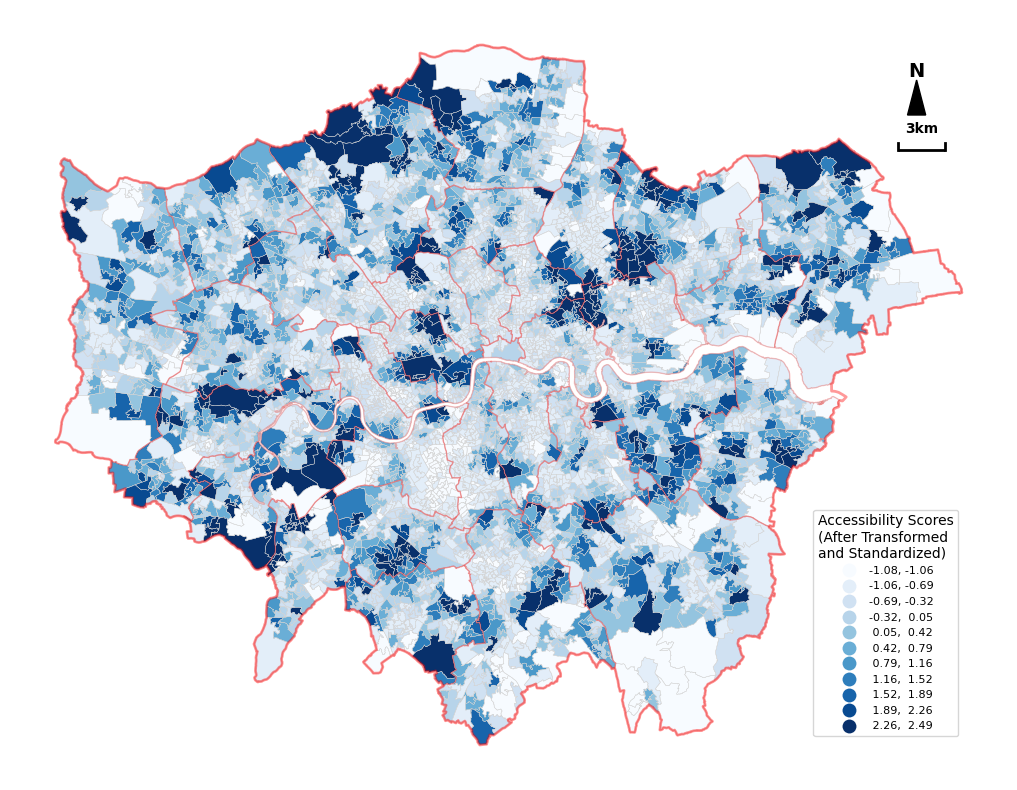

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

vmin, vmax = df_children1['Ga2SFCA_score_yj_std1'].quantile([0.05, 0.95])
breaks = np.linspace(vmin, vmax, 10)

df_children1.plot(column='Ga2SFCA_score_yj_std1',
             cmap='Blues', alpha=1,
             edgecolor='lightgrey',
             linewidth = 0.2, 
             ax=ax,
             legend=True,
             scheme='user_defined',
             classification_kwds={'bins': breaks},
             legend_kwds={'title': 'Accessibility Scores\n(After Transformed\nand Standardized)',
                         'loc': 'lower left',
                         'bbox_to_anchor': (0.8, 0.05),
                         'fontsize': 8})

#high_need_low_supply_q.plot(ax=ax, color='red', edgecolor='red', linewidth = 2, legend=True)

gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth = 0.2, alpha=0.9)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.2, facecolor='none', ax=ax)
London.plot(edgecolor='red', linewidth = 2, alpha=0.4, facecolor='none', ax=ax)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
             x_offset=0.93, y_offset=0.85)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/Child_POSaccessibility.png",dpi=300)
plt.show()

#### demand - supply plot

In [47]:
high_demand_thresh1 = df_children1['children_log_std1'].quantile(0.95)
low_supply_thresh1  = df_children1['Ga2SFCA_score_yj_std1'].quantile(0.05)

high_need_low_supply1 = df_children1[
    (df_children1['children_log_std1'] >= high_demand_thresh1) &
    (df_children1['Ga2SFCA_score_yj_std1'] <= low_supply_thresh1)
]
print(f"{len(high_need_low_supply1)}")

16


In [48]:
high_demand_thresh2 = df_children1['children_log_std1'].quantile(0.75)
low_supply_thresh2  = df_children1['Ga2SFCA_score_yj_std1'].quantile(0.25)

high_need_low_supply2 = df_children1[
    (df_children1['children_log_std1'] >= high_demand_thresh2) &
    (df_children1['Ga2SFCA_score_yj_std1'] <= low_supply_thresh2)
]
print(f"{len(high_need_low_supply2)}")

311


In [50]:
print("Extreme high demand and low supply LSOAs:")
print(high_need_low_supply1['LSOA 2021 Name'].to_string())

Extreme high demand and low supply LSOAs:
89      Barking and Dagenham 018E
110     Barking and Dagenham 004F
1148                 Croydon 025C
1391                  Ealing 026C
1474                 Enfield 014A
1604                 Enfield 003F
1607                 Enfield 014E
2453                Havering 028C
2607              Hillingdon 028C
2648              Hillingdon 028F
2741                Hounslow 021B
3619                  Newham 019B
3713                  Newham 004C
3802               Redbridge 017D
3880               Redbridge 002D
4671          Waltham Forest 011E


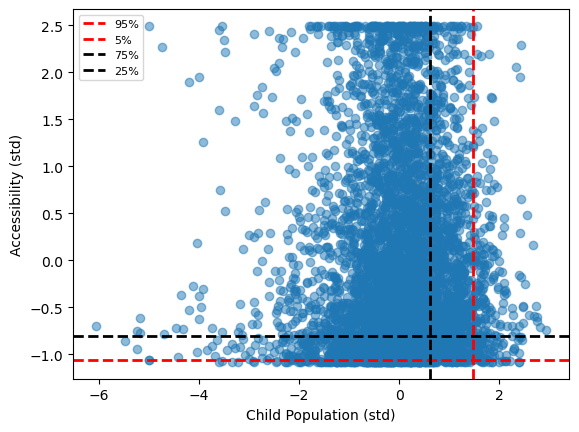

In [51]:
import matplotlib.pyplot as plt

plt.scatter(df_children1['children_log_std1'], 
            df_children1['Ga2SFCA_score_yj_std1'], 
            alpha=0.5)

plt.axvline(high_demand_thresh1, color='r', linestyle='--', linewidth=2,label='95%')
plt.axhline(low_supply_thresh1, color='r', linestyle='--', linewidth=2,label='5%')
plt.axvline(high_demand_thresh2, color='k', linestyle='--', linewidth=2,label='75%')
plt.axhline(low_supply_thresh2, color='k', linestyle='--', linewidth=2,label='25%')

plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Child Population (std)')
plt.ylabel('Accessibility (std)')
#plt.title('High-Need Low-Supply Quadrants')
#plt.savefig("pics/Child_imbalance_scatter.png",dpi=300)
plt.show()

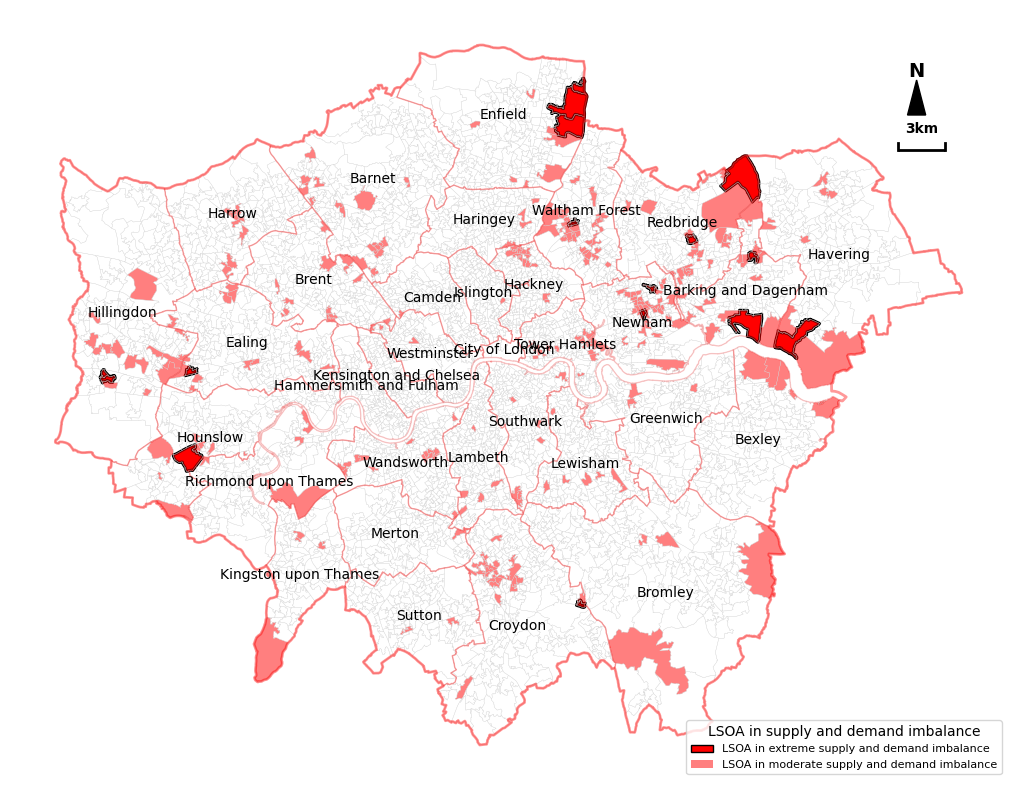

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))

vmin, vmax = df_children1['Ga2SFCA_score_yj_std1'].quantile([0.05, 0.95])
breaks = np.linspace(vmin, vmax, 10)

high_need_low_supply1.plot(ax=ax, color='red', edgecolor='black', linewidth = 2, legend=True)
high_need_low_supply2.plot(ax=ax, color='red', edgecolor='none', linewidth = 2, alpha=0.5, legend=True)
from matplotlib.patches import Patch
gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth = 0.2, alpha=0.9)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.2, facecolor='none', ax=ax)
# add the label for each LAD
for idx, row in LAD.iterrows():
    centroid = row.geometry.centroid
    plt.text(centroid.x, centroid.y, 
             row['LAD24NM'],
             fontsize=10,
             ha='center', 
             va='center',
             alpha=1)
London.plot(edgecolor='red', linewidth = 2, alpha=0.4, facecolor='none', ax=ax)
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='LSOA in extreme supply and demand imbalance'),
    Patch(facecolor='red', edgecolor='none', label='LSOA in moderate supply and demand imbalance', alpha=0.5)
]
ax.legend(handles=legend_elements, loc='lower right', title='LSOA in supply and demand imbalance', fontsize=8)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
             x_offset=0.93, y_offset=0.85)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/Children_POS_imbalance.png",dpi=300)
plt.show()

# Older Adults's demand

In [54]:
dest['PrimaryUse'].value_counts()

PrimaryUse
Amenity green space            5240
Park                           5216
River                          4216
Nature reserve                 1964
Formal garden                  1748
Recreation ground              1592
Walking/cycling route          1536
Cemetery/churchyard            1536
Canal                          1496
Common                         1136
Playing fields                  980
Play space                      916
Public woodland                 700
Civic/market square             628
Other recreational              340
Community garden                220
Allotments                      140
Village green                   120
Country park                    108
Sewage/water works              100
Adventure playground             56
City farm                        52
Road island/verge                40
Youth area                       24
Other hard surfaced areas        20
Landscaping around premises       8
                                  4
Name: count, dtyp

In [56]:
elder_keywords = ['Amenity green space', 'Community garden', 'City farm', 'Park', 
'Formal garden', 'Common','Public woodland','River','Canal']

mask1 = dest['PrimaryUse'].str.lower().isin([k.lower() for k in elder_keywords])

elder_space_ids = dest.loc[mask1, 'id'].tolist()

print(f"count of elder space: {len(elder_space_ids)}")
print(f"elder space id list: {elder_space_ids[:5]} ...")

count of elder space: 20024
elder space id list: ['0', '1', '2', '3', '4'] ...


In [57]:
# filter rows where 'id' is in children_space_ids
elder_dest = dest[dest['id'].isin(elder_space_ids)].copy()

print(elder_dest.shape)
print(elder_dest.head())

(20024, 8)
  field_1 id  AreaHa PrimaryUse                                      geometry  \
0       0  0  0.1007      Canal  POINT (536358.1774964135 181197.63192532538)   
1       1  1  0.9932      Canal   POINT (534424.9918756906 180348.5653851055)   
2       2  2  0.9932      Canal  POINT (534683.5973974898 180517.68261165055)   
3       3  3  0.9932      Canal  POINT (534600.8540096638 180480.79320236185)   
4       4  4  0.9932      Canal   POINT (534682.3096481765 180361.7032170035)   

                    lon                 lat      nodes  
0  -0.03631238564356539  51.513257304940886  263060306  
1  -0.06447830688328342   51.50609016916507  278787040  
2  -0.06068980513460138   51.50754838483266  249315586  
3  -0.06189542912832645   51.50723658582203  278313518  
4  -0.06076789934104094    51.5061469997132  249309903  


In [58]:
elder_space_ids = [int(i) for i in elder_space_ids]
distance_matrix3['destid'] = distance_matrix3['destid'].astype(int)
df_elder_od = distance_matrix3[distance_matrix3['destid'].isin(elder_space_ids)]

In [59]:
elder_od = df_elder_od.drop(columns=['destid']).T
elder_od

0      1      2      3      4      5      6      7      8      9      \
0       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
1       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
2       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
3       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4989    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4990    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4991    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4992    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4993    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   

      ...  29742  29743  29744  29745  29746  29747  29748  29749  29750  \
0     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
1     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
2     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
3     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4989  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4990  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4991  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4992  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4993  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   

      29751  
0       inf  
1       inf  
2       inf  
3       inf  
4       inf  
...     ...  
4989    inf  
4990    inf  
4991    inf  
4992    inf  
4993    inf  

[4994 rows x 20024 columns]

#### Elder spaces Accessibility for elders

In [60]:
result_df_elder = calculate_g2sfca(orig1, elder_dest, elder_od, demand_col = 'elder', time_threshold=15)

Number of origins: 4994
Number of destinations: 20024
Shape of the distance matrix: (4994, 20024)
Distance threshold: 1260.0 meters
Decay factor of the Gaussian function (β): 420.00 meters
Statistics of the weight matrix:
  Number of non-zero weights: 156782
  Range of weights: 0.000000 - 1.000000
  Average weight: 0.000328
Statistics of the Ga2SFCA scores:
  Minimum value: 0.000000
  Maximum value: 1994.956268
  Average value: 6.088583
  Number of non-zero values: 4855


In [61]:
result_df_elder['id'] = result_df_elder['id'].astype(int)

In [62]:
df_elder = df.merge(result_df_elder, on='id', how='left')
df_elder.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          4994 non-null   int64   
 1   female%_log_std             4994 non-null   float64 
 2   children%_log_std           4994 non-null   float64 
 3   elder%_log_std              4994 non-null   float64 
 4   minority_groups%_log_std    4994 non-null   float64 
 5   Buddhist%_yj_std            4994 non-null   float64 
 6   Hindu%_yj_std               4994 non-null   float64 
 7   Jewish%_yj_std              4994 non-null   float64 
 8   Muslim%_log_std             4994 non-null   float64 
 9   Sikh%_yj_std                4994 non-null   float64 
 10  Other religion%_yj_std      4994 non-null   float64 
 11  No_religion%_log_std        4994 non-null   float64 
 12  bad_heath%_log_std          4994 non-null   float64 
 13  disabled%_

#### data processing

In [63]:
df_trans1 = df_elder.copy()

cols = ['elder', 'Ga2SFCA_score']
X = df_trans1[cols].values

for col in cols:
    X = df_trans1[[col]].values
    if (df_trans1[col] > 0).all():
        # positive → log
        df_trans1[col + '_log'] = np.log1p(X)
        df_trans1[col + '_log_std1'] = scaler.fit_transform(df_trans1[[col + '_log']])
    else:
        # non-positive → Yeo-Johnson
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        df_trans1[col + '_yj'] = pt.fit_transform(X)
        df_trans1[col + '_yj_std1'] = scaler.fit_transform(df_trans1[[col + '_yj']])

df_trans1.head()

id  female%_log_std  children%_log_std  elder%_log_std  \
0   0        -2.463871          -2.816887        1.716931   
1   1        -3.881470          -3.979872        1.252814   
2   2        -2.309066          -3.451397        0.990899   
3   3        -0.933471          -1.451380       -0.292308   
4   4        -6.500336          -4.930885       -1.990881   

   minority_groups%_log_std  Buddhist%_yj_std  Hindu%_yj_std  Jewish%_yj_std  \
0                 -0.786474         -0.112070      -0.005052        1.338161   
1                 -0.623950         -0.019379      -0.543551        1.497593   
2                 -0.478675          0.256732      -0.823392        1.527591   
3                  0.726820         -0.204973      -0.584817        1.001810   
4                  0.284750          1.471405       0.500227        1.400608   

   Muslim%_log_std  Sikh%_yj_std  ...  \
0        -1.770601     -1.409412  ...   
1        -1.900242     -1.409412  ...   
2        -1.423990     -0.695025  ...   
3         1.340914     -1.409412  ...   
4        -1.429025     -0.206083  ...   

                                            geometry  LSOA 2021 Code  \
0  MULTIPOLYGON (((532151.538 181867.433, 532152....       E01000001   
1  MULTIPOLYGON (((532634.497 181926.016, 532632....       E01000002   
2  MULTIPOLYGON (((532153.703 182165.155, 532158....       E01000003   
3  MULTIPOLYGON (((533619.062 181402.364, 533639....       E01000005   
4  MULTIPOLYGON (((533376.156 181863.888, 533372....       E01032739   

        LSOA 2021 Name  elder       nodes  Ga2SFCA_score  elder_log  \
0  City of London 001A    372    20460697       0.009623   5.921578   
1  City of London 001B    278   748941508       0.008387   5.631212   
2  City of London 001C    287  1155584130       0.005326   5.662960   
3  City of London 001E    104  4715263992     128.607310   4.653960   
4  City of London 001F     62  2218344505      66.427137   4.143135   

   elder_log_std1  Ga2SFCA_score_yj  Ga2SFCA_score_yj_std1  
0        1.315521          0.009485              -0.676724  
1        0.755712          0.008282              -0.684097  
2        0.816921          0.005283              -0.702466  
3       -1.128371          0.494220               2.292983  
4       -2.113212          0.494147               2.292540  

[5 rows x 30 columns]

In [64]:
df_elder1 = df_trans1[['id','LSOA 2021 Code', 'LSOA 2021 Name','elder_log_std1', 'Ga2SFCA_score_yj_std1', 'geometry']]
df_elder1.head()

id LSOA 2021 Code       LSOA 2021 Name  elder_log_std1  \
0   0      E01000001  City of London 001A        1.315521   
1   1      E01000002  City of London 001B        0.755712   
2   2      E01000003  City of London 001C        0.816921   
3   3      E01000005  City of London 001E       -1.128371   
4   4      E01032739  City of London 001F       -2.113212   

   Ga2SFCA_score_yj_std1                                           geometry  
0              -0.676724  MULTIPOLYGON (((532151.538 181867.433, 532152....  
1              -0.684097  MULTIPOLYGON (((532634.497 181926.016, 532632....  
2              -0.702466  MULTIPOLYGON (((532153.703 182165.155, 532158....  
3               2.292983  MULTIPOLYGON (((533619.062 181402.364, 533639....  
4               2.292540  MULTIPOLYGON (((533376.156 181863.888, 533372....

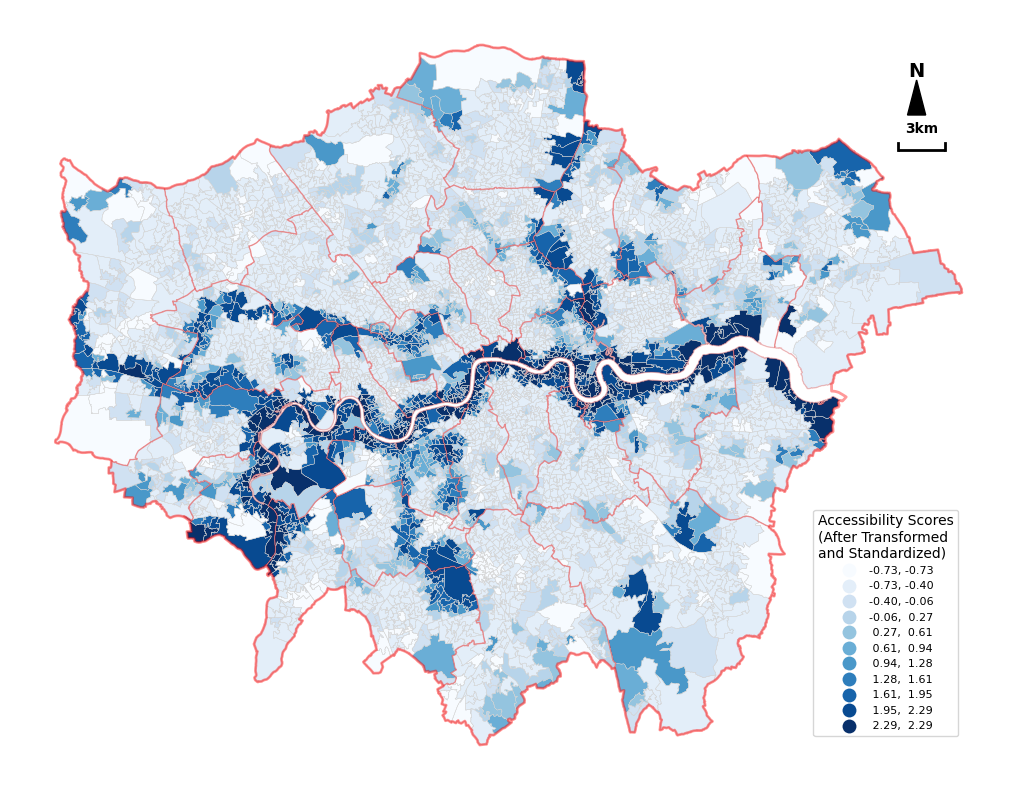

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

vmin, vmax = df_elder1['Ga2SFCA_score_yj_std1'].quantile([0.05, 0.95])
breaks = np.linspace(vmin, vmax, 10)

df_elder1.plot(column='Ga2SFCA_score_yj_std1',
             cmap='Blues', alpha=1,
             edgecolor='lightgrey',
             linewidth = 0.2, 
             ax=ax,
             legend=True,
             scheme='user_defined',
             classification_kwds={'bins': breaks},
             legend_kwds={'title': 'Accessibility Scores\n(After Transformed\nand Standardized)',
                         'loc': 'lower left',
                         'bbox_to_anchor': (0.8, 0.05),
                         'fontsize': 8})

gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth = 0.2, alpha=0.9)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.2, facecolor='none', ax=ax)
London.plot(edgecolor='red', linewidth = 2, alpha=0.4, facecolor='none', ax=ax)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
             x_offset=0.93, y_offset=0.85)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/Elder_POSaccessibility.png",dpi=300)
plt.show()

#### demand - supply plot

In [66]:
high_demand_thresh1 = df_elder1['elder_log_std1'].quantile(0.95)
low_supply_thresh1  = df_elder1['Ga2SFCA_score_yj_std1'].quantile(0.05)

high_need_low_supply1 = df_elder1[
    (df_elder1['elder_log_std1'] >= high_demand_thresh1) &
    (df_elder1['Ga2SFCA_score_yj_std1'] <= low_supply_thresh1)
]
print(f"{len(high_need_low_supply1)}")

20


In [67]:
high_demand_thresh2 = df_elder1['elder_log_std1'].quantile(0.75)
low_supply_thresh2  = df_elder1['Ga2SFCA_score_yj_std1'].quantile(0.25)

high_need_low_supply2 = df_elder1[
    (df_elder1['elder_log_std1'] >= high_demand_thresh2) &
    (df_elder1['Ga2SFCA_score_yj_std1'] <= low_supply_thresh2)
]
print(f"{len(high_need_low_supply2)}")

364


In [ ]:
#high_need_low_supply1.to_csv('high_need_low_supply_elder1.csv', index=False)

In [69]:
#high_need_low_supply2.to_csv('high_need_low_supply_elder2.csv', index=False)

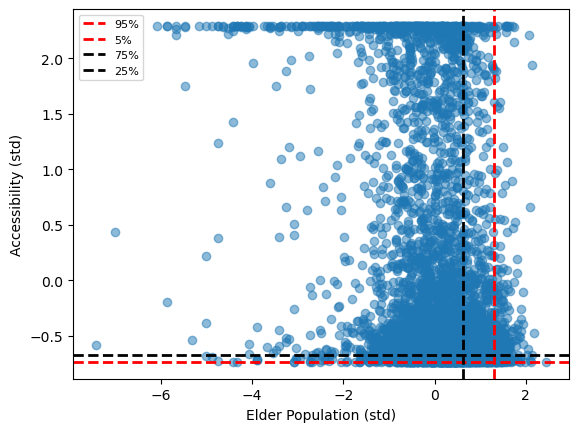

In [70]:
plt.scatter(df_elder1['elder_log_std1'], 
            df_elder1['Ga2SFCA_score_yj_std1'], 
            alpha=0.5)

plt.axvline(high_demand_thresh1, color='r', linestyle='--', linewidth=2,label='95%')
plt.axhline(low_supply_thresh1, color='r', linestyle='--', linewidth=2,label='5%')
plt.axvline(high_demand_thresh2, color='k', linestyle='--', linewidth=2,label='75%')
plt.axhline(low_supply_thresh2, color='k', linestyle='--', linewidth=2,label='25%')

plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Elder Population (std)')
plt.ylabel('Accessibility (std)')
#plt.title('High-Need with Low-Supply LSOAs')
#plt.savefig("pics/Elder_imbalance_scatter.png",dpi=300)
plt.show()

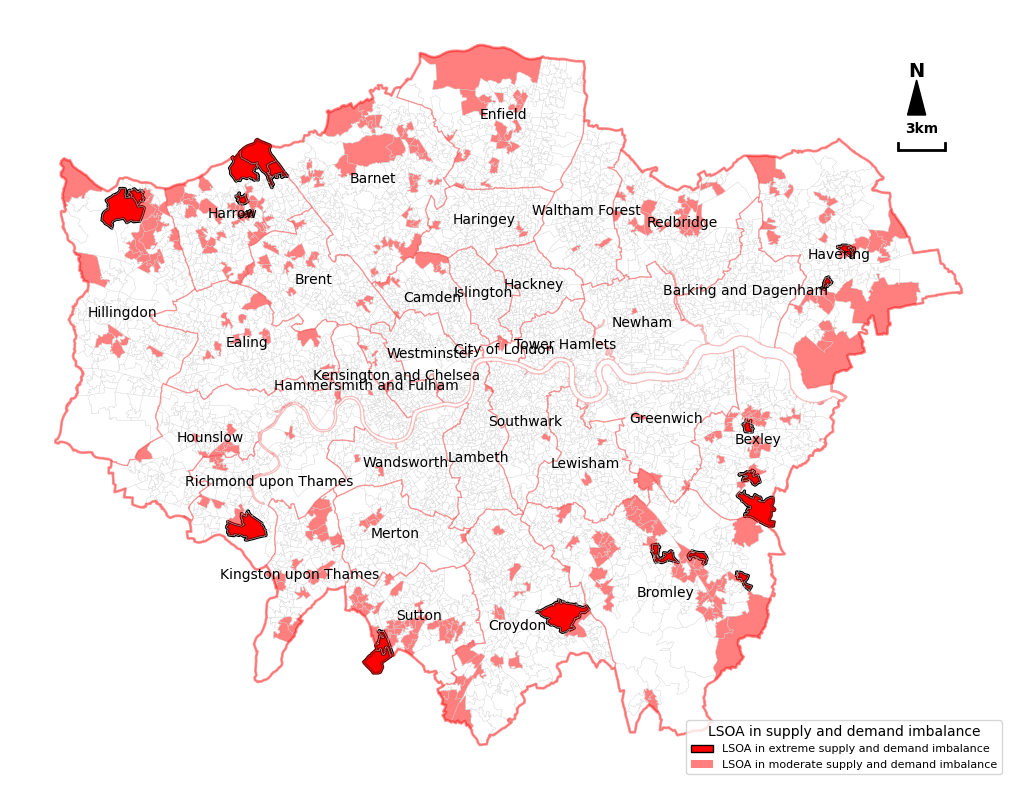

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))

vmin, vmax = df_elder1['Ga2SFCA_score_yj_std1'].quantile([0.05, 0.95])
breaks = np.linspace(vmin, vmax, 10)

high_need_low_supply1.plot(ax=ax, color='red', edgecolor='black', linewidth = 2, legend=True)
high_need_low_supply2.plot(ax=ax, color='red', edgecolor='none', linewidth = 2, alpha=0.5, legend=True)

gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth = 0.2, alpha=0.9)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.2, facecolor='none', ax=ax)
# add the label for each LAD
for idx, row in LAD.iterrows():
    centroid = row.geometry.centroid
    plt.text(centroid.x, centroid.y, 
             row['LAD24NM'],
             fontsize=10,
             ha='center', 
             va='center',
             alpha=1)
London.plot(edgecolor='red', linewidth = 2, alpha=0.4, facecolor='none', ax=ax)
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='LSOA in extreme supply and demand imbalance'),
    Patch(facecolor='red', edgecolor='none', label='LSOA in moderate supply and demand imbalance', alpha=0.5)
]
ax.legend(handles=legend_elements, loc='lower right', title='LSOA in supply and demand imbalance', fontsize=8)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
             x_offset=0.93, y_offset=0.85)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/Elder_POS_imbalance.png",dpi=300)
plt.show()

# People in bad health and disabled Accessibility for disabled people

In [72]:
dest['PrimaryUse'].value_counts()

PrimaryUse
Amenity green space            5240
Park                           5216
River                          4216
Nature reserve                 1964
Formal garden                  1748
Recreation ground              1592
Walking/cycling route          1536
Cemetery/churchyard            1536
Canal                          1496
Common                         1136
Playing fields                  980
Play space                      916
Public woodland                 700
Civic/market square             628
Other recreational              340
Community garden                220
Allotments                      140
Village green                   120
Country park                    108
Sewage/water works              100
Adventure playground             56
City farm                        52
Road island/verge                40
Youth area                       24
Other hard surfaced areas        20
Landscaping around premises       8
                                  4
Name: count, dtyp

In [73]:
badhealth_keywords = ['Amenity green space', 'Community garden','Park','Formal garden',
'Public Woodland','Nature reserve','River','Canal']

mask3 = dest['PrimaryUse'].str.lower().isin([k.lower() for k in badhealth_keywords])

badhealth_space_ids = dest.loc[mask3, 'id'].tolist()

print(f"count of badhealth space: {len(badhealth_space_ids)}")
print(f"badhealth space id list: {badhealth_space_ids[:5]} ...")

count of badhealth space: 20800
badhealth space id list: ['0', '1', '2', '3', '4'] ...


In [74]:
# filter rows where 'id' is in children_space_ids
badhealth_dest = dest[dest['id'].isin(badhealth_space_ids)].copy()

print(badhealth_dest.shape)
print(badhealth_dest.head())

(20800, 8)
  field_1 id  AreaHa PrimaryUse                                      geometry  \
0       0  0  0.1007      Canal  POINT (536358.1774964135 181197.63192532538)   
1       1  1  0.9932      Canal   POINT (534424.9918756906 180348.5653851055)   
2       2  2  0.9932      Canal  POINT (534683.5973974898 180517.68261165055)   
3       3  3  0.9932      Canal  POINT (534600.8540096638 180480.79320236185)   
4       4  4  0.9932      Canal   POINT (534682.3096481765 180361.7032170035)   

                    lon                 lat      nodes  
0  -0.03631238564356539  51.513257304940886  263060306  
1  -0.06447830688328342   51.50609016916507  278787040  
2  -0.06068980513460138   51.50754838483266  249315586  
3  -0.06189542912832645   51.50723658582203  278313518  
4  -0.06076789934104094    51.5061469997132  249309903  


In [75]:
badhealth_space_ids = [int(i) for i in badhealth_space_ids]
distance_matrix3['destid'] = distance_matrix3['destid'].astype(int)
df_badhealth_od = distance_matrix3[distance_matrix3['destid'].isin(badhealth_space_ids)]
badhealth_od = df_badhealth_od.drop(columns=['destid']).T
badhealth_od

0      1      2      3      4      5      6      7      8      9      \
0       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
1       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
2       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
3       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4       inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4989    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4990    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4991    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4992    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4993    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf   

      ...  29742  29743  29744  29745  29746  29747  29748  29749  29750  \
0     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
1     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
2     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
3     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4     ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4989  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4990  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4991  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4992  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   
4993  ...    inf    inf    inf    inf    inf    inf    inf    inf    inf   

      29751  
0       inf  
1       inf  
2       inf  
3       inf  
4       inf  
...     ...  
4989    inf  
4990    inf  
4991    inf  
4992    inf  
4993    inf  

[4994 rows x 20800 columns]

#### bad health and disabled accessibilty

In [76]:
result_df_badhealth = calculate_g2sfca(orig1, badhealth_dest, badhealth_od, demand_col = 'bad_health', time_threshold=15)

Number of origins: 4994
Number of destinations: 20800
Shape of the distance matrix: (4994, 20800)
Distance threshold: 1260.0 meters
Decay factor of the Gaussian function (β): 420.00 meters
Statistics of the weight matrix:
  Number of non-zero weights: 155215
  Range of weights: 0.000000 - 1.000000
  Average weight: 0.000316
Statistics of the Ga2SFCA scores:
  Minimum value: 0.000000
  Maximum value: 2113.554170
  Average value: 11.162771
  Number of non-zero values: 4860


In [77]:
result_df_badhealth['id'] = result_df_badhealth['id'].astype(int)
df_badhealth = df.merge(result_df_badhealth, on='id', how='left')
df_badhealth.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          4994 non-null   int64   
 1   female%_log_std             4994 non-null   float64 
 2   children%_log_std           4994 non-null   float64 
 3   elder%_log_std              4994 non-null   float64 
 4   minority_groups%_log_std    4994 non-null   float64 
 5   Buddhist%_yj_std            4994 non-null   float64 
 6   Hindu%_yj_std               4994 non-null   float64 
 7   Jewish%_yj_std              4994 non-null   float64 
 8   Muslim%_log_std             4994 non-null   float64 
 9   Sikh%_yj_std                4994 non-null   float64 
 10  Other religion%_yj_std      4994 non-null   float64 
 11  No_religion%_log_std        4994 non-null   float64 
 12  bad_heath%_log_std          4994 non-null   float64 
 13  disabled%_

#### data processing

In [78]:
df_trans1 = df_badhealth.copy()

cols = ['bad_health', 'Ga2SFCA_score']
X = df_trans1[cols].values

for col in cols:
    X = df_trans1[[col]].values
    if (df_trans1[col] > 0).all():
        # positive → log
        df_trans1[col + '_log'] = np.log1p(X)
        df_trans1[col + '_log_std1'] = scaler.fit_transform(df_trans1[[col + '_log']])
    else:
        # non-positive → Yeo-Johnson
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        df_trans1[col + '_yj'] = pt.fit_transform(X)
        df_trans1[col + '_yj_std1'] = scaler.fit_transform(df_trans1[[col + '_yj']])

df_trans1.head()

id  female%_log_std  children%_log_std  elder%_log_std  \
0   0        -2.463871          -2.816887        1.716931   
1   1        -3.881470          -3.979872        1.252814   
2   2        -2.309066          -3.451397        0.990899   
3   3        -0.933471          -1.451380       -0.292308   
4   4        -6.500336          -4.930885       -1.990881   

   minority_groups%_log_std  Buddhist%_yj_std  Hindu%_yj_std  Jewish%_yj_std  \
0                 -0.786474         -0.112070      -0.005052        1.338161   
1                 -0.623950         -0.019379      -0.543551        1.497593   
2                 -0.478675          0.256732      -0.823392        1.527591   
3                  0.726820         -0.204973      -0.584817        1.001810   
4                  0.284750          1.471405       0.500227        1.400608   

   Muslim%_log_std  Sikh%_yj_std  ...  \
0        -1.770601     -1.409412  ...   
1        -1.900242     -1.409412  ...   
2        -1.423990     -0.695025  ...   
3         1.340914     -1.409412  ...   
4        -1.429025     -0.206083  ...   

                                            geometry  LSOA 2021 Code  \
0  MULTIPOLYGON (((532151.538 181867.433, 532152....       E01000001   
1  MULTIPOLYGON (((532634.497 181926.016, 532632....       E01000002   
2  MULTIPOLYGON (((532153.703 182165.155, 532158....       E01000003   
3  MULTIPOLYGON (((533619.062 181402.364, 533639....       E01000005   
4  MULTIPOLYGON (((533376.156 181863.888, 533372....       E01032739   

        LSOA 2021 Name  bad_health       nodes  Ga2SFCA_score  bad_health_log  \
0  City of London 001A          28    20460697       0.067592        3.367296   
1  City of London 001B          31   748941508       0.045749        3.465736   
2  City of London 001C          49  1155584130       0.013720        3.912023   
3  City of London 001E          80  4715263992     181.277121        4.394449   
4  City of London 001F          26  2218344505     108.444418        3.295837   

   bad_health_log_std1  Ga2SFCA_score_yj  Ga2SFCA_score_yj_std1  
0            -1.911037          0.062593              -0.618659  
1            -1.695560          0.043405              -0.696407  
2            -0.718673          0.013501              -0.817576  
3             0.337318          0.737931               2.117793  
4            -2.067455          0.737292               2.115205  

[5 rows x 30 columns]

In [79]:
df_badhealth1 = df_trans1[['id','LSOA 2021 Code', 'LSOA 2021 Name','bad_health_log_std1', 'Ga2SFCA_score_yj_std1', 'geometry']]
df_badhealth1.head()

id LSOA 2021 Code       LSOA 2021 Name  bad_health_log_std1  \
0   0      E01000001  City of London 001A            -1.911037   
1   1      E01000002  City of London 001B            -1.695560   
2   2      E01000003  City of London 001C            -0.718673   
3   3      E01000005  City of London 001E             0.337318   
4   4      E01032739  City of London 001F            -2.067455   

   Ga2SFCA_score_yj_std1                                           geometry  
0              -0.618659  MULTIPOLYGON (((532151.538 181867.433, 532152....  
1              -0.696407  MULTIPOLYGON (((532634.497 181926.016, 532632....  
2              -0.817576  MULTIPOLYGON (((532153.703 182165.155, 532158....  
3               2.117793  MULTIPOLYGON (((533619.062 181402.364, 533639....  
4               2.115205  MULTIPOLYGON (((533376.156 181863.888, 533372....

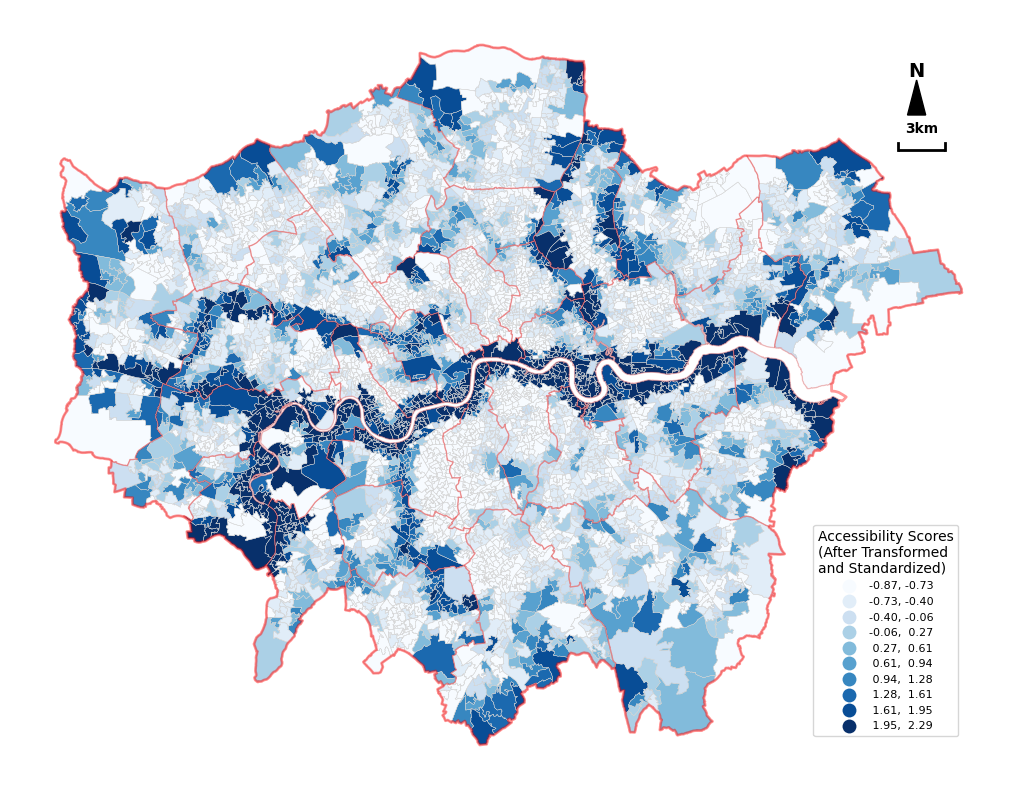

In [80]:
fig, ax = plt.subplots(figsize=(12, 8))

vmin, vmax = df_elder1['Ga2SFCA_score_yj_std1'].quantile([0.05, 0.95])
breaks = np.linspace(vmin, vmax, 10)

df_badhealth1.plot(column='Ga2SFCA_score_yj_std1',
             cmap='Blues', alpha=1,
             edgecolor='lightgrey',
             linewidth = 0.2, 
             ax=ax,
             legend=True,
             scheme='user_defined',
             classification_kwds={'bins': breaks},
             legend_kwds={'title': 'Accessibility Scores\n(After Transformed\nand Standardized)',
                         'loc': 'lower left',
                         'bbox_to_anchor': (0.8, 0.05),
                         'fontsize': 8})

gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth = 0.2, alpha=0.9)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.2, facecolor='none', ax=ax)
London.plot(edgecolor='red', linewidth = 2, alpha=0.4, facecolor='none', ax=ax)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
             x_offset=0.93, y_offset=0.85)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/Badhealth_POSaccessibility.png",dpi=300)
plt.show()

#### demand - supply plot

In [81]:
high_demand_thresh1 = df_badhealth1['bad_health_log_std1'].quantile(0.95)
low_supply_thresh1  = df_badhealth1['Ga2SFCA_score_yj_std1'].quantile(0.05)

high_need_low_supply1 = df_badhealth1[
    (df_badhealth1['bad_health_log_std1'] >= high_demand_thresh1) &
    (df_badhealth1['Ga2SFCA_score_yj_std1'] <= low_supply_thresh1)
]
print(f"{len(high_need_low_supply1)}")

4


In [82]:
high_demand_thresh2 = df_badhealth1['bad_health_log_std1'].quantile(0.75)
low_supply_thresh2  = df_badhealth1['Ga2SFCA_score_yj_std1'].quantile(0.25)

high_need_low_supply2 = df_badhealth1[
    (df_badhealth1['bad_health_log_std1'] >= high_demand_thresh2) &
    (df_badhealth1['Ga2SFCA_score_yj_std1'] <= low_supply_thresh2)
]
print(f"{len(high_need_low_supply2)}")

333


In [ ]:
high_need_low_supply1.sort_values(by='bad_health_log_std1', ascending=True)

id LSOA 2021 Code             LSOA 2021 Name  bad_health_log_std1  \
3713  3713      E01003587                Newham 004C             1.519389   
24      24      E01000027  Barking and Dagenham 001A             1.550660   
1607  1607      E01033926               Enfield 014E             1.671459   
2166  2166      E01002093              Haringey 005B             1.715093   

      Ga2SFCA_score_yj_std1                                           geometry  
3713              -0.870216  MULTIPOLYGON (((541547.628 185478.674, 541551 ...  
24                -0.869356  MULTIPOLYGON (((548881.304 190819.98, 548881.1...  
1607              -0.872284  MULTIPOLYGON (((536221.996 196448.06, 536243.4...  
2166              -0.871358  MULTIPOLYGON (((532642.596 191539, 532652.132 ...

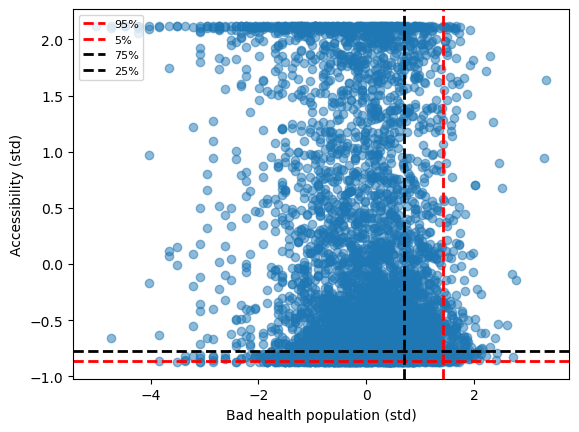

In [84]:
plt.scatter(df_badhealth1['bad_health_log_std1'], 
            df_badhealth1['Ga2SFCA_score_yj_std1'], 
            alpha=0.5)

plt.axvline(high_demand_thresh1, color='r', linestyle='--', linewidth=2,label='95%')
plt.axhline(low_supply_thresh1, color='r', linestyle='--', linewidth=2,label='5%')
plt.axvline(high_demand_thresh2, color='k', linestyle='--', linewidth=2,label='75%')
plt.axhline(low_supply_thresh2, color='k', linestyle='--', linewidth=2,label='25%')

plt.legend(loc='upper left', fontsize=8)

plt.xlabel('Bad health population (std)')
plt.ylabel('Accessibility (std)')
#plt.title('High-Need with Low-Supply LSOAs')
#plt.savefig("pics/Badhealth_imbalance_scatter.png",dpi=300)
plt.show()

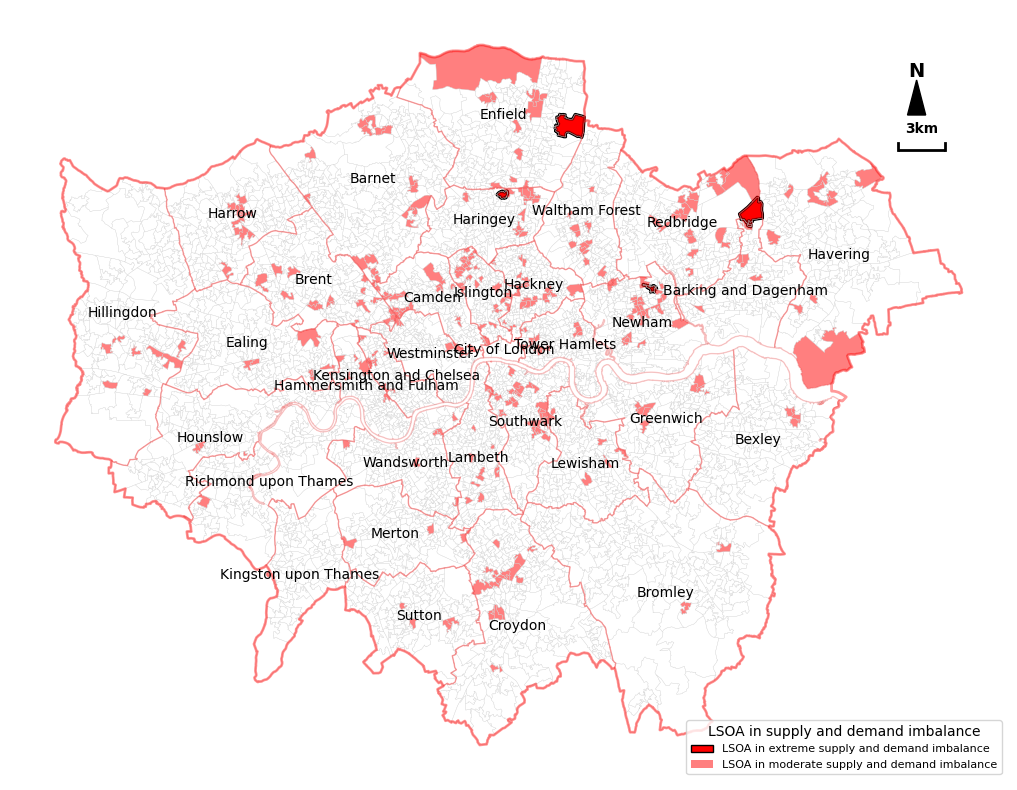

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))

vmin, vmax = df_badhealth1['Ga2SFCA_score_yj_std1'].quantile([0.05, 0.95])
breaks = np.linspace(vmin, vmax, 10)

high_need_low_supply1.plot(ax=ax, color='red', edgecolor='black', linewidth = 2, legend=True)
high_need_low_supply2.plot(ax=ax, color='red', edgecolor='none', linewidth = 2, alpha=0.5, legend=True)

gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth = 0.2, alpha=0.9)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.2, facecolor='none', ax=ax)
# add the label for each LAD
for idx, row in LAD.iterrows():
    centroid = row.geometry.centroid
    plt.text(centroid.x, centroid.y, 
             row['LAD24NM'],
             fontsize=10,
             ha='center', 
             va='center',
             alpha=1)
London.plot(edgecolor='red', linewidth = 2, alpha=0.4, facecolor='none', ax=ax)
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='LSOA in extreme supply and demand imbalance'),
    Patch(facecolor='red', edgecolor='none', label='LSOA in moderate supply and demand imbalance', alpha=0.5)
]
ax.legend(handles=legend_elements, loc='lower right', title='LSOA in supply and demand imbalance', fontsize=8)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
             x_offset=0.93, y_offset=0.85)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/Badhealth_POS_imbalance.png",dpi=300)
plt.show()